# SHAP MNIST

This notebook shows how SHAP works using the MNIST dataset and a PyTorch model.

The code is based on the [SHAP MNIST example](https://shap.readthedocs.io/en/stable/example_notebooks/image_examples/image_classification/PyTorch%20Deep%20Explainer%20MNIST%20example.html). The notebook with the example code is available [on GitHub](https://github.com/slundberg/shap/blob/master/notebooks/image_examples/image_classification/PyTorch%20Deep%20Explainer%20MNIST%20example.ipynb).

## Neural network training

In [1]:
import torch, torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F

import numpy as np
import shap

import matplotlib.pyplot as plt

In [2]:
batch_size = 128
device = torch.device('cpu')

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 320)
        x = self.fc_layers(x)
        return x

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output.log(), target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output.log(), target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist_data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist_data', train=False, transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size, shuffle=True)

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [3]:
num_epochs = 5
for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.308299
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.230037
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.417374
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.084842
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.776686

Test set: Average loss: 0.0052, Accuracy: 8844/10000 (88%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.689793
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.911420
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.642709
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.564983
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.488782

Test set: Average loss: 0.0028, Accuracy: 9320/10000 (93%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.399929
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.486332
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.424222
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.517453
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.273432

Test set: Average loss: 0.0020, Accuracy: 9493/10000 (95%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.257969
Train Epoch: 4 [12800/60000 (21%)]	Lo

## SHAP feature attributions

Extract a batch of images and their labels from the test set.

In [4]:
batch = next(iter(test_loader))
images, target = batch

datad, targetd = images.to(device), target.to(device)

Get their predicted probabilities and predicted label (with argmax).

In [5]:
output = model(datad)
pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

# Convert to numpy only once to save time
target_np = target.numpy()
pred_np = pred.numpy()

"Select a set of background examples to take an expectation over" (from the [SHAP README](https://github.com/slundberg/shap#deep-learning-example-with-deepexplainer-tensorflowkeras-models))

In [6]:
BACKGROUND_SIZE = 100
background = images[:BACKGROUND_SIZE]
e = shap.DeepExplainer(model, background)

What is left from the test batch will be used to show feature attribution.

In [7]:
test_images = images[BACKGROUND_SIZE:]

Show the SHAP feature atribution for each image. We could have passed the entire array of images to `image_plot`, but we would lose resolution with that (see the test code). Processing each image separately results in a larger graph, making the attributions easier to see.

How to read the attributions:

- Red pixels increases the probability of a class being predicted
- Blue pixels decrease the probability of a class being predicted

See an explanation of "red vs. blue" [on this page of the SHAP documentation](https://shap.readthedocs.io/en/latest/example_notebooks/image_examples/image_classification/Image%20Multi%20Class.html#Visualizing-SHAP-values-output).

**NOTE** that a disadvantage of ploting each image separately is that the SHAP value scale changes from one image to the next. We cannot compare the colors from one image to others in this format. To compare colors acorss images we need to plot all of them with one call to `image_plot`, as it's done in the original sample code. See the test code after this section if you want to see all images in one plot.

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


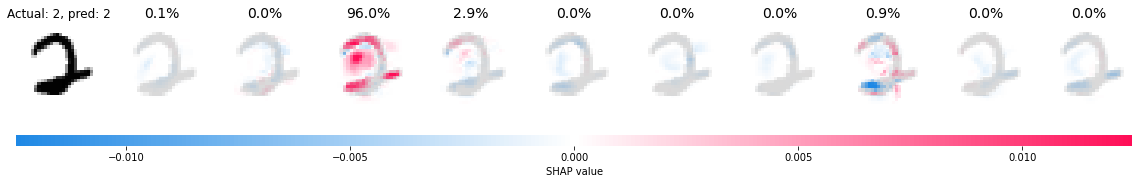

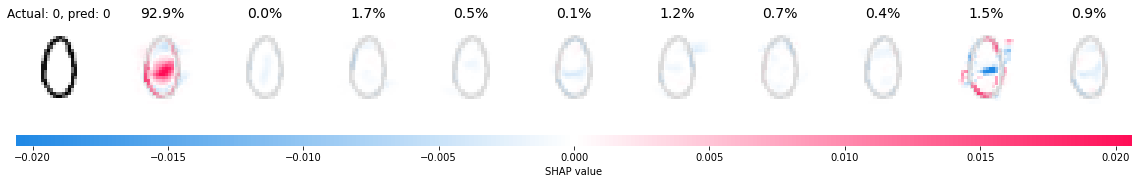

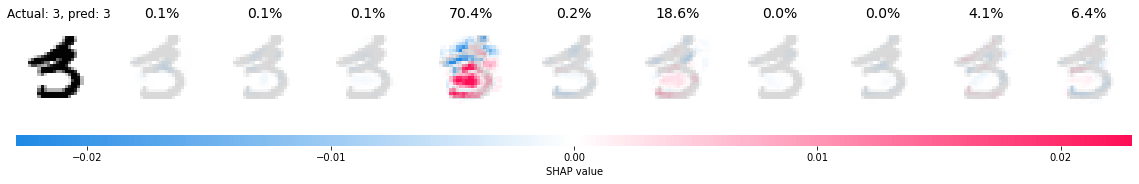

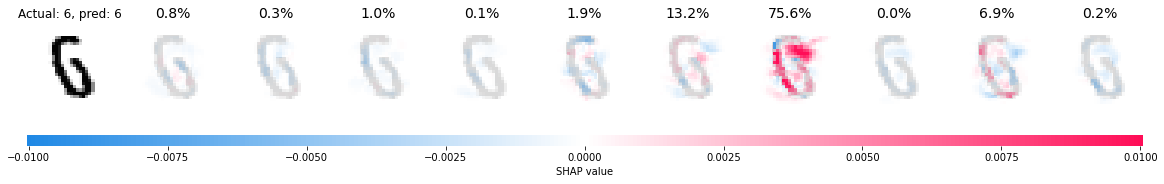

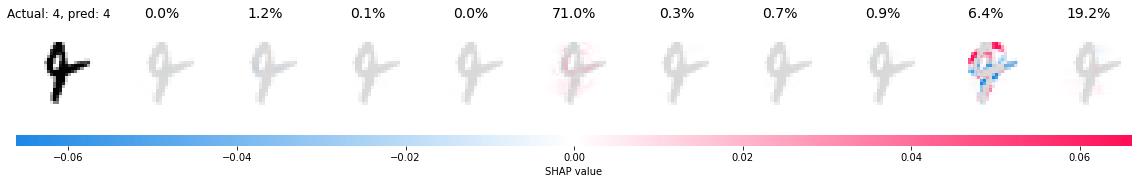

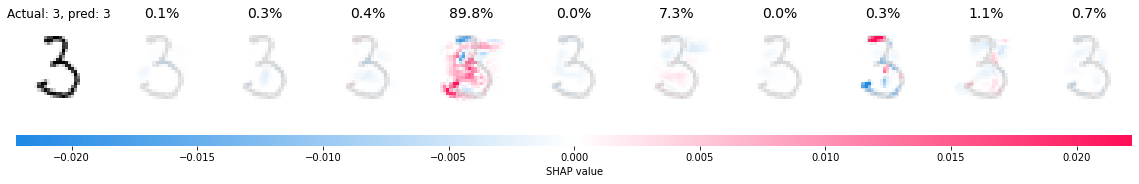

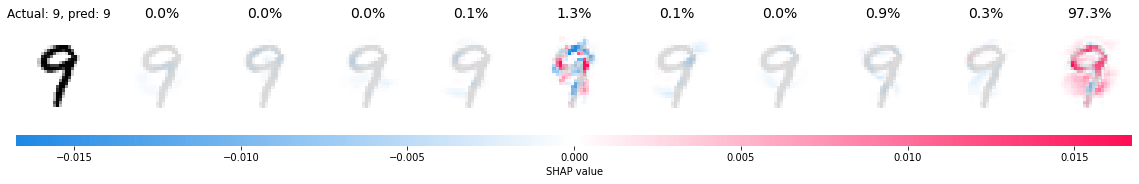

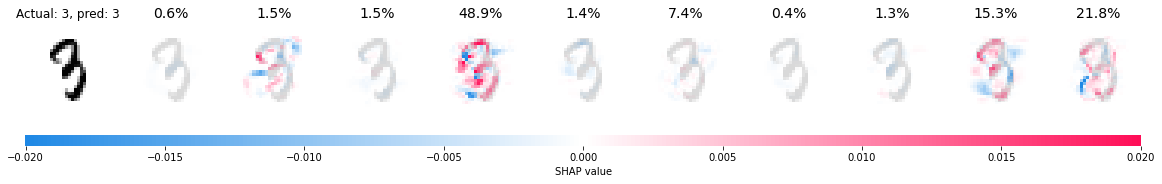

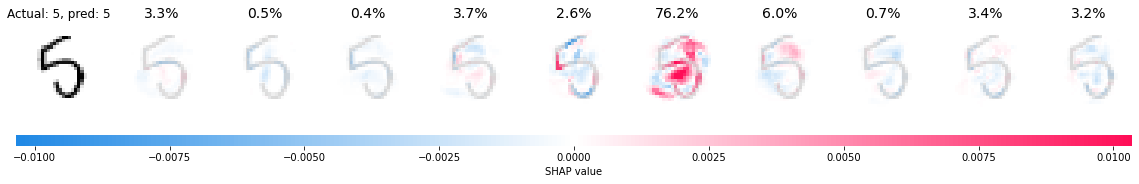

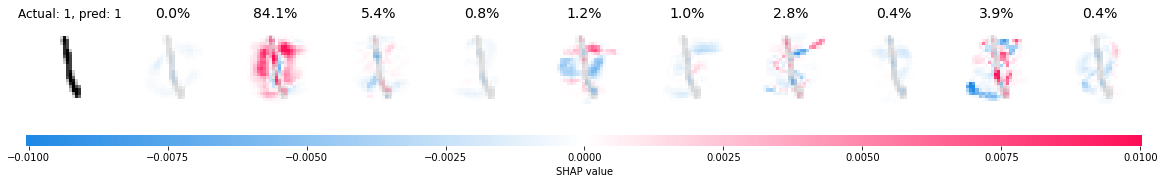

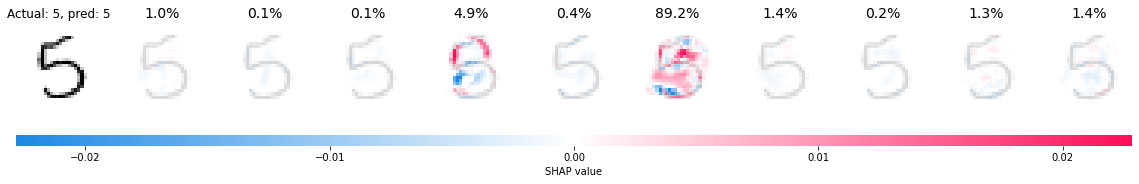

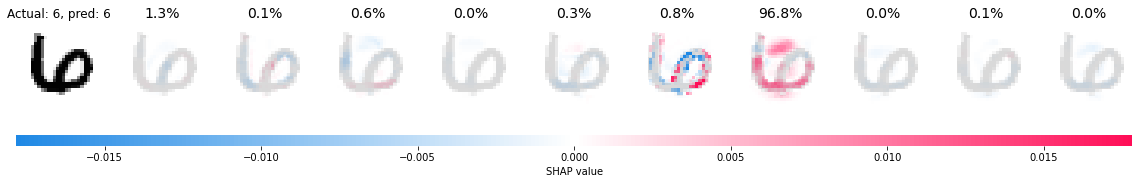

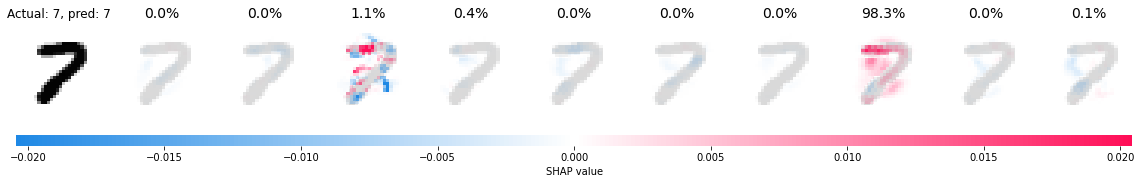

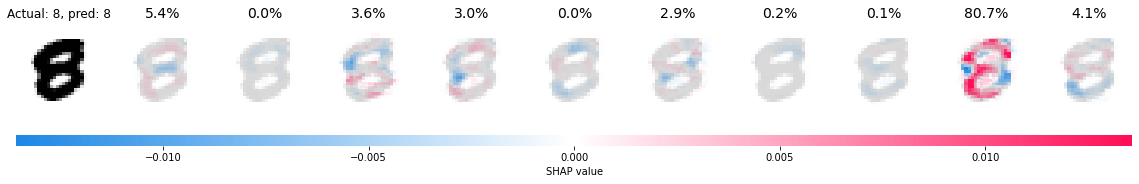

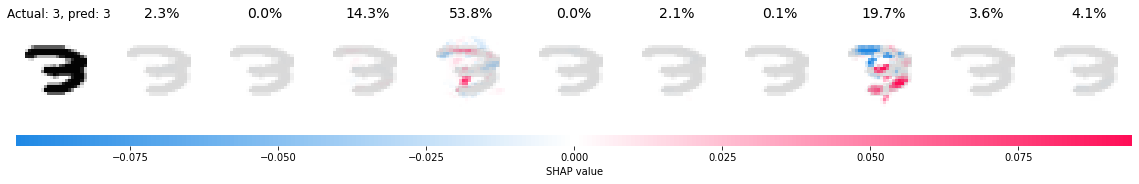

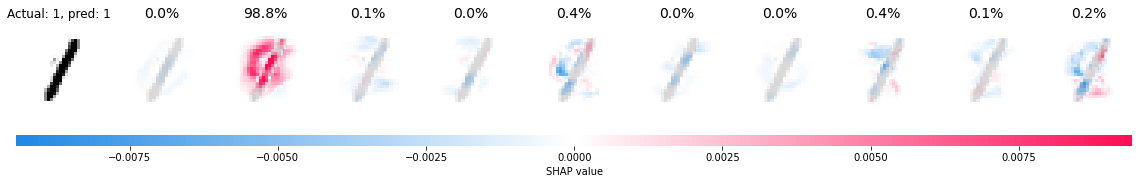

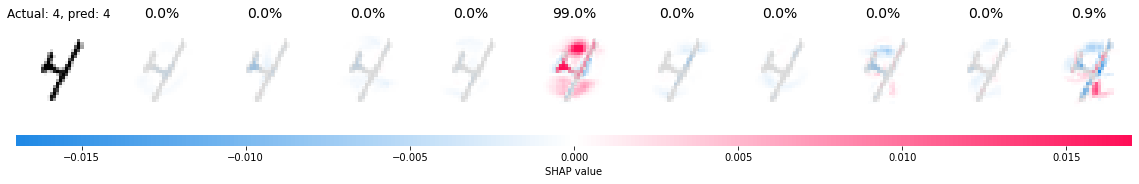

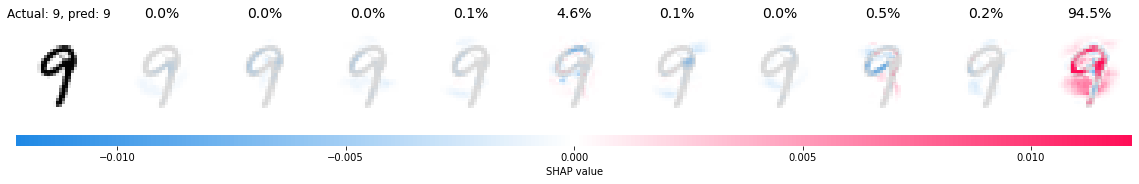

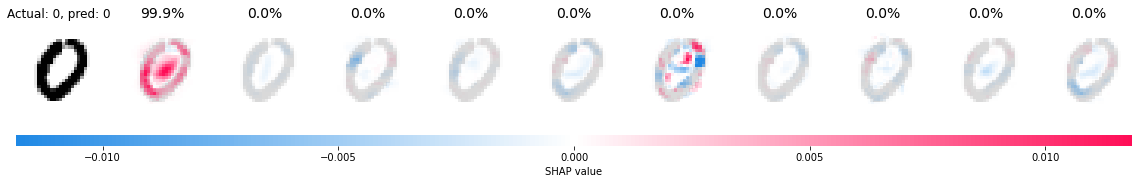

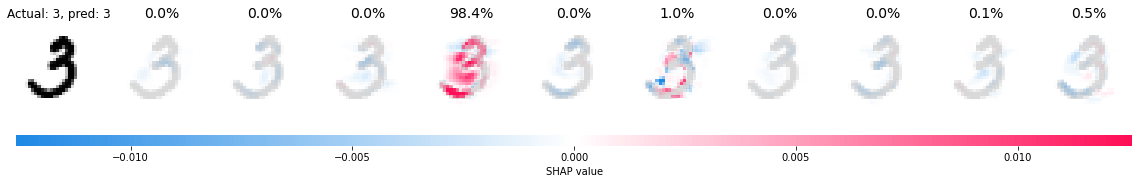

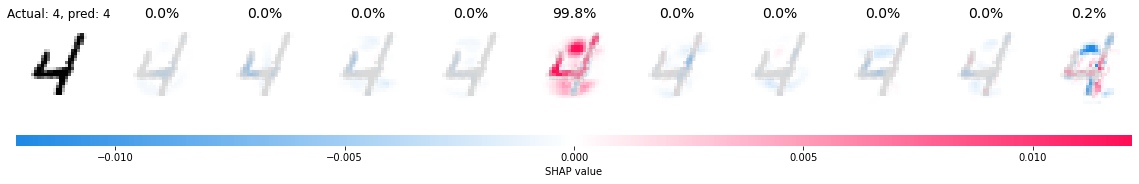

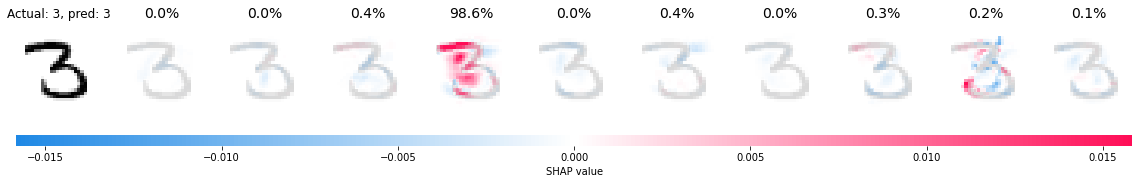

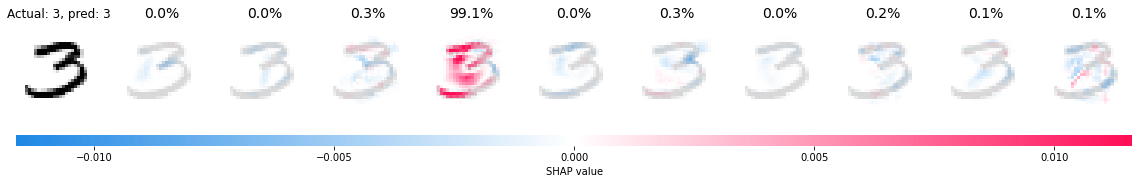

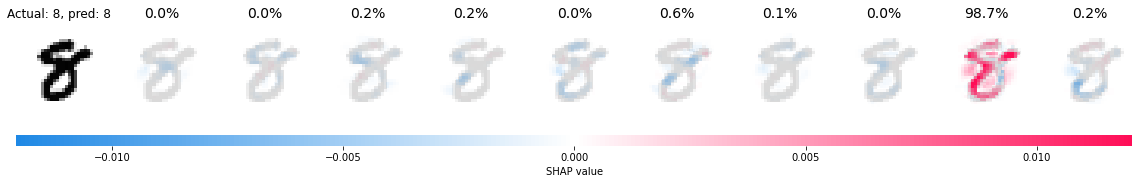

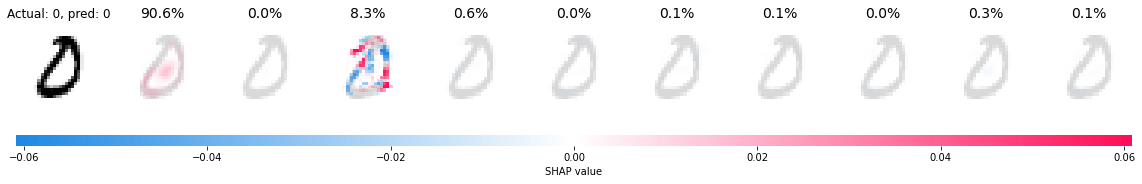

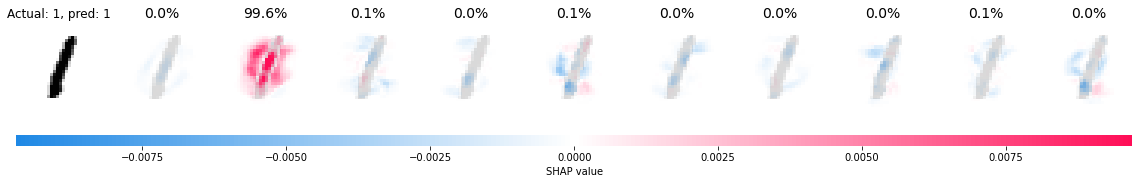

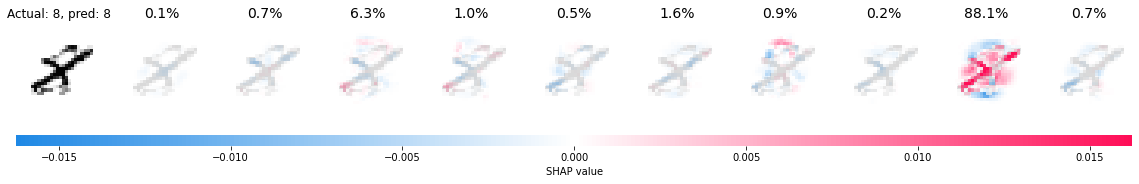

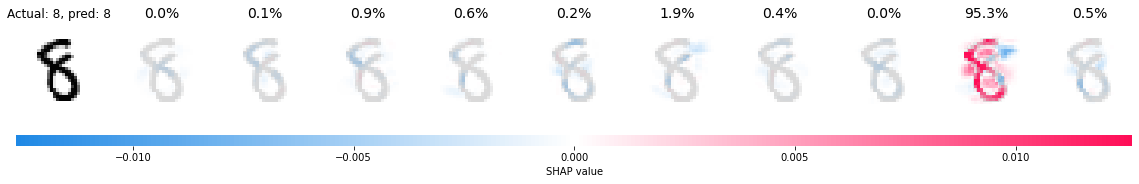

In [8]:
for i in range(0,len(test_images)):
    ti = test_images[[i]]
    sv = e.shap_values(ti)
    sn = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in sv]
    tn = np.swapaxes(np.swapaxes(ti.numpy(), 1, -1), 1, 2)
    
    # Prepare the attribution plot, but draw it yet - we will add more info to it
    shap.image_plot(sn, -tn, show=False)

    # Prpare to augment the plot
    fig = plt.gcf()
    allaxes = fig.get_axes()

    # Show the actual/predicted class
    test_index = BACKGROUND_SIZE + i
    allaxes[0].set_title('Actual: {}, pred: {}'.format(
        target_np[test_index], pred_np[test_index][0]))

    # Show the probability of each class
    # There are 11 axes for each picture: 1 for the digit + 10 for each SHAP
    # There is a last axis for the scale - we don't want to apply a label for that one
    prob = output[test_index].detach().numpy()
    for x in range(1, len(allaxes)-1):
        allaxes[x].set_title('{:.1%}'.format(prob[x-1]), fontsize=14)
    plt.show()


# Test code

This section has the original code from the [SHAP MNIST example](https://shap.readthedocs.io/en/stable/example_notebooks/image_examples/image_classification/PyTorch%20Deep%20Explainer%20MNIST%20example.html). Use this section to check that the code in the previous section is showing the correct SHAP images.

To make the code comparable, we reuse the same images loaded in the previous section, but we redo all calculations following the sample code, to ensure that we didn't introduce a bug in the previous section.

The sequence of digits in this section and their feature attributions must match the ones in the previous sections.

In [9]:
# Turn the test code on when needed to not pollute the notebook
TEST_CODE = True

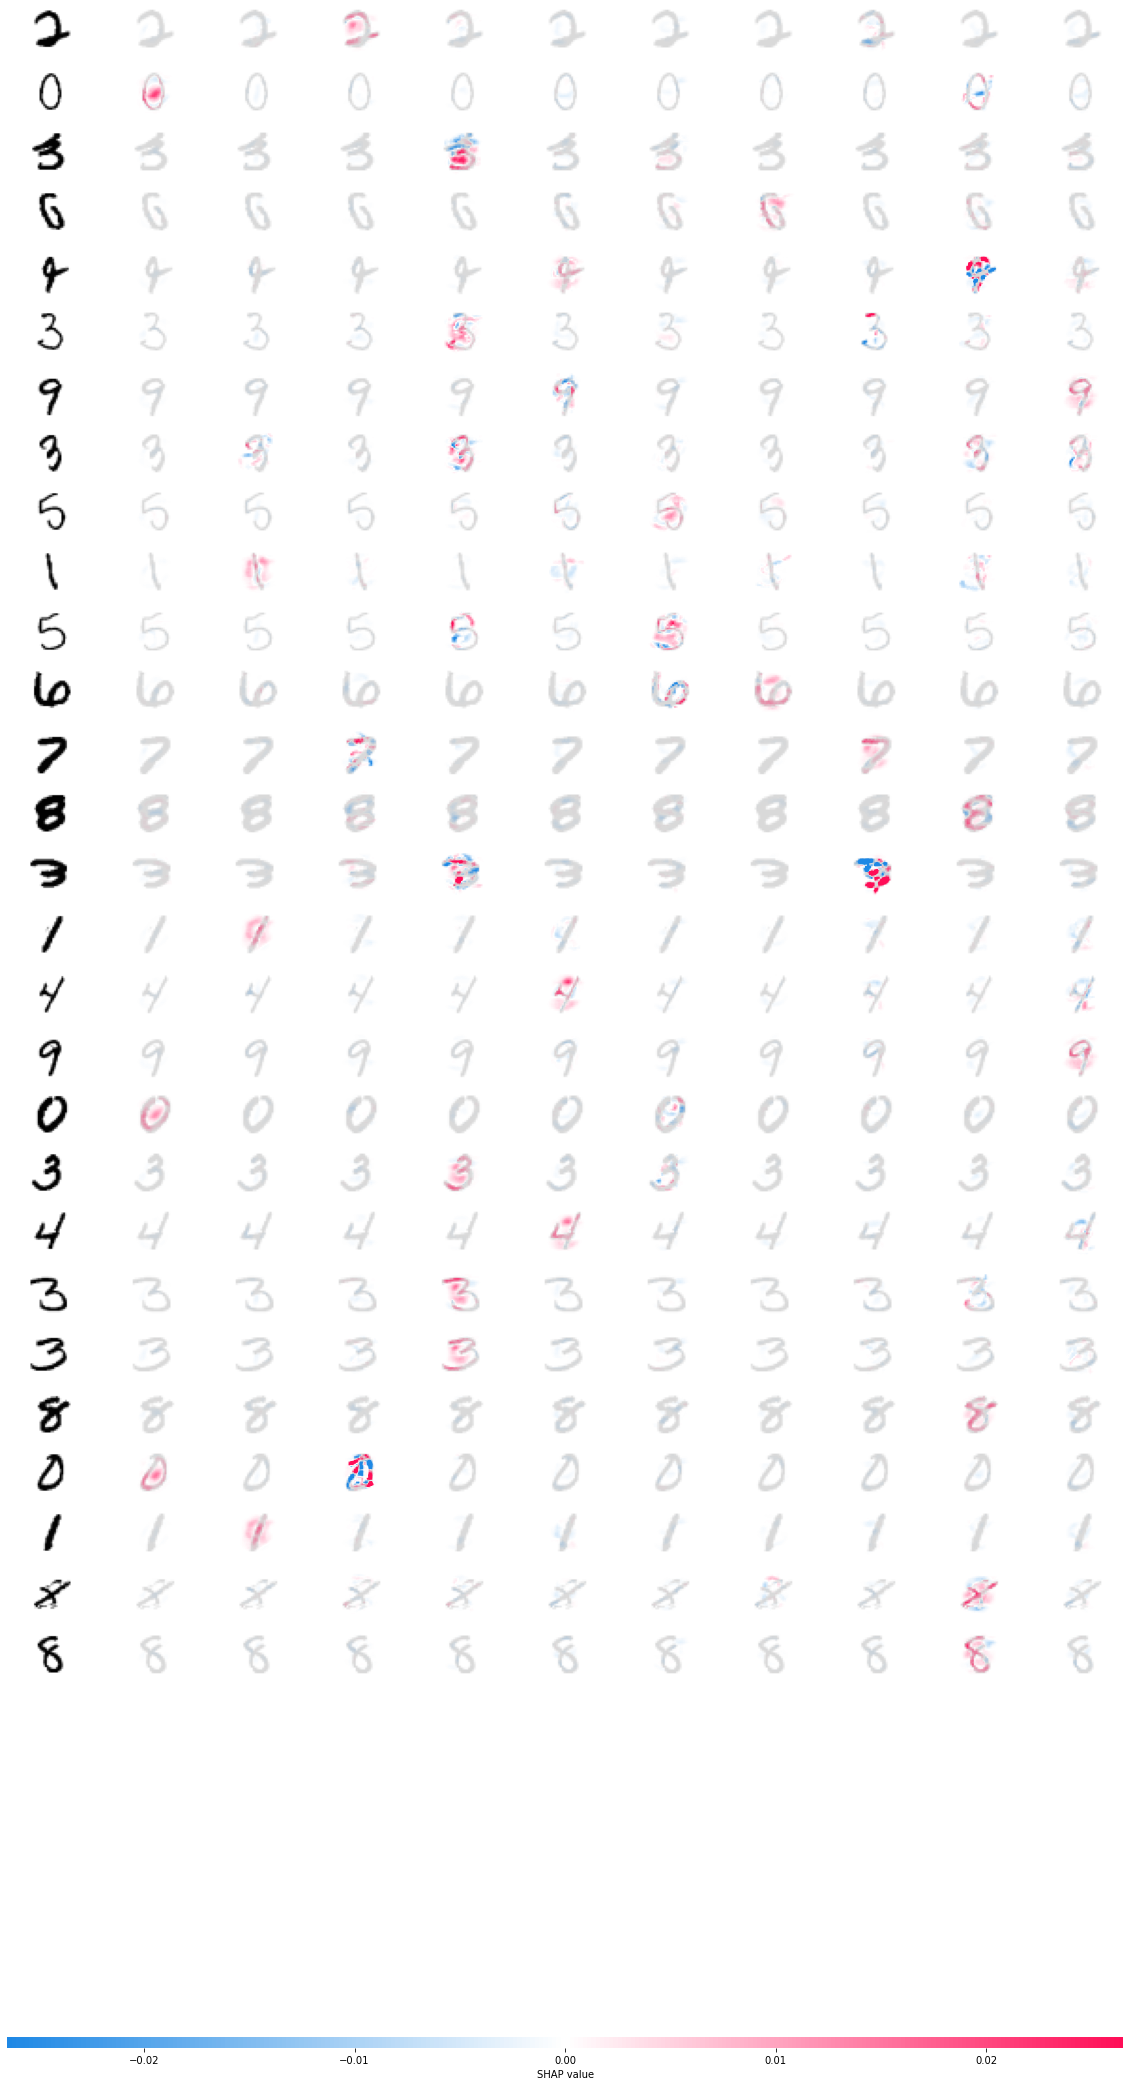

In [10]:
if TEST_CODE:
    e = shap.DeepExplainer(model, background)
    shap_values = e.shap_values(test_images)
    
    shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
    test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)
    
    shap.image_plot(shap_numpy, -test_numpy)